<h1 style="text-align: center;">Channel type assignment</h1>


In [1]:
# Import useful packages
import pandas as pd
from sentence_transformers import SentenceTransformer
import re
import numpy as np
import pickle
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

c:\Users\167266\nlp\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
# Create useful functions

# This function processes a string and converts it into the corresponding dictionary.
def parse_telegram_dict_string(text):
    if not isinstance(text, str):
        return text
    
    if not (text.startswith('{') and text.endswith('}')):
        return text
    
    # Define the namespace for evaluation
    namespace = {
        'datetime': datetime,
        'tzinfo': datetime.timezone
    }
    
    try:
        # Use eval with a controlled namespace
        result = eval(text, {"__builtins__": {}}, namespace)
        return result
    except Exception as e:
        # Fallback to original text if parsing fails
        print(f"Error parsing: {e}")
        return text

<h2 style="text-align: center;">Read and filter data</h2>

In [3]:
# Seed channels
covid_6years = pd.read_csv(r"C:\Users\167266\Documents\PhD\Hierarchy\Data\Source channels\covid_6years.csv")
pb_6years = pd.read_csv(r"C:\Users\167266\Documents\PhD\Hierarchy\Data\Source channels\pb_6years.csv")
trump_6years = pd.read_csv(r"C:\Users\167266\Documents\PhD\Hierarchy\Data\Source channels\trump_6years.csv")
white_6years = pd.read_csv(r"C:\Users\167266\Documents\PhD\Hierarchy\Data\Source channels\white_6years.csv")
qanon_6years = pd.read_csv(r"C:\Users\167266\Documents\PhD\Hierarchy\Data\Source channels\qanon_6years.csv")

# Source channels
covid_source = pd.read_csv(r"C:\Users\167266\Documents\PhD\Hierarchy\Data\Source channels\covid_1year.csv")
pb_source = pd.read_csv(r"C:\Users\167266\Documents\PhD\Hierarchy\Data\Source channels\pb_1year.csv")
trump_source = pd.read_csv(r"C:\Users\167266\Documents\PhD\Hierarchy\Data\Source channels\trump_1year.csv")
white_source = pd.read_csv(r"C:\Users\167266\Documents\PhD\Hierarchy\Data\Source channels\white_1year.csv")
qanon_source = pd.read_csv(r"C:\Users\167266\Documents\PhD\Hierarchy\Data\Source channels\qanon_1year.csv")

# Mentioned channels
covid_mentioned = pd.read_csv(r"F:\._PhD\Publications\Hierarchy\Data\MentionedChannels\covid_1year.csv")
pb_mentioned = pd.read_csv(r"F:\._PhD\Publications\Hierarchy\Data\MentionedChannels\pb_1year.csv")
trump_mentioned = pd.read_csv(r"F:\._PhD\Publications\Hierarchy\Data\MentionedChannels\trump_1year.csv")
white_mentioned = pd.read_csv(r"F:\._PhD\Publications\Hierarchy\Data\MentionedChannels\white_1year.csv")
qanon_mentioned = pd.read_csv(r"F:\._PhD\Publications\Hierarchy\Data\MentionedChannels\qanon_1year.csv")

C:\Users\167266\AppData\Local\Temp\ipykernel_11588\4046775603.py:2: DtypeWarning: Columns (4,11,12,21,22,23,24,25,26,27,30,34,38,40,42,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  covid_6years = pd.read_csv(r"C:\Users\167266\Documents\PhD\Hierarchy\Data\Source channels\covid_6years.csv")
C:\Users\167266\AppData\Local\Temp\ipykernel_11588\4046775603.py:3: DtypeWarning: Columns (11,34,38,40,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  pb_6years = pd.read_csv(r"C:\Users\167266\Documents\PhD\Hierarchy\Data\Source channels\pb_6years.csv")
C:\Users\167266\AppData\Local\Temp\ipykernel_11588\4046775603.py:4: DtypeWarning: Columns (4,11,12,21,22,23,24,25,26,27,30,34,38,39,40,42,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  trump_6years = pd.read_csv(r"C:\Users\167266\Documents\PhD\Hierarchy\Data\Source channels\trump_6years.csv")
C:\Users\167266\AppData\Local\Temp\ipykernel_11588\404

In [4]:
z_list = pd.read_csv("F:\._PhD\Publications\Hierarchy\Early work\Zhong\Data\Zhong_ChannelIDs_JQD2024_updated.csv")
z_list_found = z_list[z_list['channel_found']]
z_list_found = list(z_list_found['label'])
my_list = list(covid_6years.group.unique()) + list(pb_6years.group.unique()) + list(trump_6years.group.unique()) + list(white_6years.group.unique()) + list(qanon_6years.group.unique())

print("Number of channels found at latest collection: ", len(my_list))
print("Number of channels unfound at latest collection: ", len([x for x in z_list_found if x not in my_list]))
print("List of channels unfound at latest collection: ", [x for x in z_list_found if x not in my_list])

Number of channels found at latest collection:  362
Number of channels unfound at latest collection:  10
List of channels unfound at latest collection:  ['fightingcovidtyranny', 'coviddiscussionforum', 'proudtilldeath', 'covidredpills', 'mikelasater', 'officalproudboyseire', 'dangeroustimes', 'covid19agenda', 'corona_5g_rollout', 'truthshepherdcovid19']


In [5]:
start_date = covid_source['date'].min()
end_date = covid_source['date'].max()

print(start_date, end_date)

2024-03-01 00:00:02+00:00 2025-02-28 23:59:56+00:00


In [6]:
def filter_by_date(df, start, end):
    return df[(df['date'] > start) & (df['date'] <= end)]

covid_seed = filter_by_date(covid_6years, start_date, end_date)
pb_seed = filter_by_date(pb_6years, start_date, end_date)
trump_seed = filter_by_date(trump_6years, start_date, end_date)
qanon_seed = filter_by_date(qanon_6years, start_date, end_date)
white_seed = filter_by_date(white_6years, start_date, end_date)

In [7]:
n_channels_1year = len(list(covid_seed.group.unique())) + len(list(pb_seed.group.unique())) + len(list(trump_seed.group.unique())) + len(list(qanon_seed.group.unique())) + len(list(white_seed.group.unique()))

print("Number of channels found at latest collection & active during selected year: ", n_channels_1year)

Number of channels found at latest collection & active during selected year:  214


<h2 style="text-align: center;">Process seed channels</h2>

In [8]:
# Initialize model once
model = SentenceTransformer('all-MiniLM-L6-v2')

# Helper: remove URLs
def remove_urls(text):
    return re.sub(r'http\S+|www\.\S+', '', str(text))

# Helper: compute average embedding by channel
def get_average_embedding_by_channel(df):
    # Clean and group messages
    channel_messages = (
        df.dropna(subset=['sender_username', 'message'])
          .assign(message=lambda df_: df_['message'].apply(remove_urls))
          .groupby('channel_name')['message']
          .apply(lambda msgs: ' '.join(msgs))
          .to_dict()
    )
    
    # Compute embeddings
    channel_names = list(channel_messages.keys())
    texts = list(channel_messages.values())
    embeddings = model.encode(texts, show_progress_bar=True, convert_to_tensor=False)

    # Store channel-wise embeddings
    channel_embeddings = {name: emb for name, emb in zip(channel_names, embeddings)}

    # Compute average embedding
    all_embeddings = np.stack(list(channel_embeddings.values()))
    avg_embedding = all_embeddings.mean(axis=0)

    return avg_embedding, channel_embeddings, channel_messages

# # average_embedding_covid_seed, channel_embeddings_covid_seed, channel_messages_covid_seed = get_average_embedding_by_channel(covid_seed)
# # average_embedding_pb_seed, channel_embeddings_pb_seed, channel_messages_pb_seed = get_average_embedding_by_channel(pb_seed)
# # average_embedding_trump_seed, channel_embeddings_trump_seed, channel_messages_trump_seed = get_average_embedding_by_channel(trump_seed)
# # average_embedding_qanon_seed, channel_embeddings_qanon_seed, channel_messages_qanon_seed = get_average_embedding_by_channel(qanon_seed)
# # average_embedding_white_seed, channel_embeddings_white_seed, channel_messages_white_seed = get_average_embedding_by_channel(white_seed)

In [9]:
# # Export all five sets
# with open('average_embedding_covid_seed.pkl', 'wb') as f:
#     pickle.dump(average_embedding_covid_seed, f)
# with open('channel_embeddings_covid_seed.pkl', 'wb') as f:
#     pickle.dump(channel_embeddings_covid_seed, f)
# with open('channel_messages_covid_seed.pkl', 'wb') as f:
#     pickle.dump(channel_messages_covid_seed, f)

# with open('average_embedding_pb_seed.pkl', 'wb') as f:
#     pickle.dump(average_embedding_pb_seed, f)
# with open('channel_embeddings_pb_seed.pkl', 'wb') as f:
#     pickle.dump(channel_embeddings_pb_seed, f)
# with open('channel_messages_pb_seed.pkl', 'wb') as f:
#     pickle.dump(channel_messages_pb_seed, f)

# with open('average_embedding_trump_seed.pkl', 'wb') as f:
#     pickle.dump(average_embedding_trump_seed, f)
# with open('channel_embeddings_trump_seed.pkl', 'wb') as f:
#     pickle.dump(channel_embeddings_trump_seed, f)
# with open('channel_messages_trump_seed.pkl', 'wb') as f:
#     pickle.dump(channel_messages_trump_seed, f)

# with open('average_embedding_qanon_seed.pkl', 'wb') as f:
#     pickle.dump(average_embedding_qanon_seed, f)
# with open('channel_embeddings_qanon_seed.pkl', 'wb') as f:
#     pickle.dump(channel_embeddings_qanon_seed, f)
# with open('channel_messages_qanon_seed.pkl', 'wb') as f:
#     pickle.dump(channel_messages_qanon_seed, f)

# with open('average_embedding_white_seed.pkl', 'wb') as f:
#     pickle.dump(average_embedding_white_seed, f)
# with open('channel_embeddings_white_seed.pkl', 'wb') as f:
#     pickle.dump(channel_embeddings_white_seed, f)
# with open('channel_messages_white_seed.pkl', 'wb') as f:
#     pickle.dump(channel_messages_white_seed, f)

# Import all five sets
with open('seed_embeddings_pkl/average_embedding_covid_seed.pkl', 'rb') as f:
    average_embedding_covid_seed = pickle.load(f)
with open('seed_embeddings_pkl/channel_embeddings_covid_seed.pkl', 'rb') as f:
    channel_embeddings_covid_seed = pickle.load(f)
with open('seed_embeddings_pkl/channel_messages_covid_seed.pkl', 'rb') as f:
    channel_messages_covid_seed = pickle.load(f)

with open('seed_embeddings_pkl/average_embedding_pb_seed.pkl', 'rb') as f:
    average_embedding_pb_seed = pickle.load(f)
with open('seed_embeddings_pkl/channel_embeddings_pb_seed.pkl', 'rb') as f:
    channel_embeddings_pb_seed = pickle.load(f)
with open('seed_embeddings_pkl/channel_messages_pb_seed.pkl', 'rb') as f:
    channel_messages_pb_seed = pickle.load(f)

with open('seed_embeddings_pkl/average_embedding_trump_seed.pkl', 'rb') as f:
    average_embedding_trump_seed = pickle.load(f)
with open('seed_embeddings_pkl/channel_embeddings_trump_seed.pkl', 'rb') as f:
    channel_embeddings_trump_seed = pickle.load(f)
with open('seed_embeddings_pkl/channel_messages_trump_seed.pkl', 'rb') as f:
    channel_messages_trump_seed = pickle.load(f)

with open('seed_embeddings_pkl/average_embedding_qanon_seed.pkl', 'rb') as f:
    average_embedding_qanon_seed = pickle.load(f)
with open('seed_embeddings_pkl/channel_embeddings_qanon_seed.pkl', 'rb') as f:
    channel_embeddings_qanon_seed = pickle.load(f)
with open('seed_embeddings_pkl/channel_messages_qanon_seed.pkl', 'rb') as f:
    channel_messages_qanon_seed = pickle.load(f)

with open('seed_embeddings_pkl/average_embedding_white_seed.pkl', 'rb') as f:
    average_embedding_white_seed = pickle.load(f)
with open('seed_embeddings_pkl/channel_embeddings_white_seed.pkl', 'rb') as f:
    channel_embeddings_white_seed = pickle.load(f)
with open('seed_embeddings_pkl/channel_messages_white_seed.pkl', 'rb') as f:
    channel_messages_white_seed = pickle.load(f)


In [10]:
# Compute cosine similarity with all centroids for each channel


from sklearn.metrics.pairwise import cosine_similarity

# Dictionary of all average embeddings
average_embeddings = {
    'covid': average_embedding_covid_seed,
    'pb': average_embedding_pb_seed,
    'trump': average_embedding_trump_seed,
    'qanon': average_embedding_qanon_seed,
    'white': average_embedding_white_seed
}

# Dictionary of all channel embeddings
channel_embeddings = {
    'covid': channel_embeddings_covid_seed,
    'pb': channel_embeddings_pb_seed,
    'trump': channel_embeddings_trump_seed,
    'qanon': channel_embeddings_qanon_seed,
    'white': channel_embeddings_white_seed
}

def compute_channel_similarity_df(average_embeddings: dict, channel_embeddings: dict) -> pd.DataFrame:
    """
    Compute cosine similarity between each channel embedding and all average embeddings,
    and determine the predicted type based on the highest similarity.

    Parameters:
    - average_embeddings (dict): Mapping from type name to average embedding vector.
    - channel_embeddings (dict): Mapping from type name to dict of channel embeddings.

    Returns:
    - pd.DataFrame: A DataFrame with cosine similarities, true types, predicted types, and mismatch flags.
    """
    # Flatten all channel embeddings with compound keys: "type::channel_name"
    all_channels = {}
    for type_label, channels in channel_embeddings.items():
        for channel_name, emb in channels.items():
            all_channels[f'{type_label}::{channel_name}'] = emb

    # Compute cosine similarities
    results = []
    for channel_key, channel_emb in all_channels.items():
        true_type = channel_key.split('::')[0]
        row = {
            'channel': channel_key,
            'true_type': true_type
        }
        for avg_key, avg_emb in average_embeddings.items():
            row[f'sim_to_{avg_key}'] = cosine_similarity([channel_emb], [avg_emb])[0][0]
        results.append(row)

    # Create DataFrame
    similarity_df = pd.DataFrame(results)

    # Determine predicted type from highest similarity
    sim_cols = [f'sim_to_{k}' for k in average_embeddings.keys()]
    similarity_df['predicted_type'] = similarity_df[sim_cols].idxmax(axis=1).str.replace('sim_to_', '', regex=False)

    # Flag mismatches
    similarity_df['mismatch'] = similarity_df['true_type'] != similarity_df['predicted_type']

    return similarity_df


similarity_df = compute_channel_similarity_df(average_embeddings, channel_embeddings)

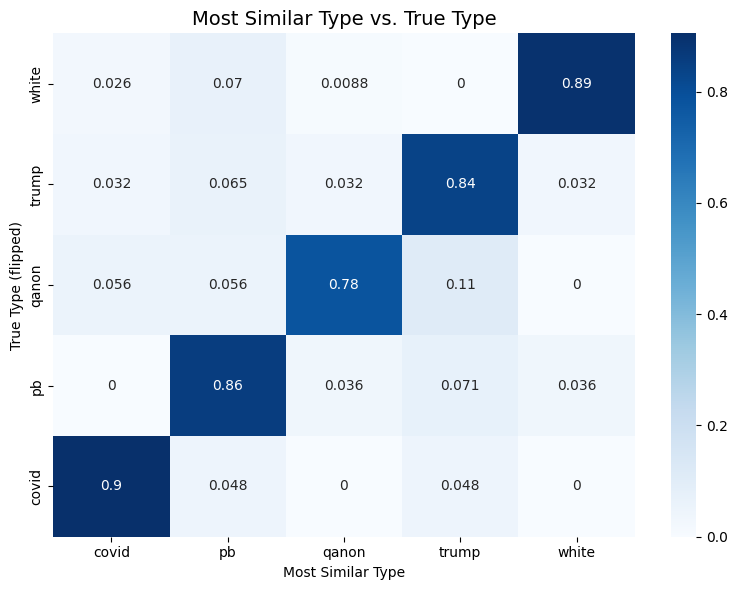

In [11]:
# Step 1: Select only the similarity columns
sim_cols = similarity_df.filter(regex="^sim_to")

# Step 2: Get the column (type) with highest similarity per row
most_similar_type = sim_cols.idxmax(axis=1)

# Step 3: Extract just the type name (e.g., 'covid' from 'sim_to_covid')
most_similar_type_clean = most_similar_type.str.replace("sim_to_", "", regex=False)

# Step 4: Combine with true_type
type_match_df = pd.DataFrame({
    'true_type': similarity_df['true_type'],
    'top_sim_type': most_similar_type_clean
})

# Step 5: Crosstabulate
match_table = pd.crosstab(type_match_df['true_type'], type_match_df['top_sim_type'], normalize='index')

# Step 6: Flip rows (index) to reverse y-axis
match_table_flipped = match_table.loc[match_table.index[::-1]]

# Step 7: Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(match_table_flipped, annot=True, cmap="Blues", cbar=True)

plt.title("Most Similar Type vs. True Type", fontsize=14)
plt.xlabel("Most Similar Type")
plt.ylabel("True Type (flipped)")
plt.tight_layout()
plt.show()


In [12]:
# Count mismatches
num_mismatches = similarity_df['mismatch'].sum()
total_channels = len(similarity_df)

print(f"Channels where top similarity ≠ true type: {num_mismatches} / {total_channels}")


Channels where top similarity ≠ true type: 27 / 212


In [13]:
similarity_df

,channel,true_type,sim_to_covid,sim_to_pb,sim_to_trump,sim_to_qanon,sim_to_white,predicted_type,mismatch
0,covid::codemonkeyz,covid,0.447314,0.597925,0.668424,0.651266,0.388838,trump,True
1,covid::copsforcovidtruth,covid,0.621424,0.393991,0.321686,0.357651,0.250528,covid,False
2,covid::coronaausschussalleanhoerungen,covid,0.366049,0.189835,0.160010,0.171672,0.260146,covid,False
3,covid::coronavirusdatadump,covid,0.582185,0.186814,0.165415,0.231596,0.166537,covid,False
4,covid::coronavirusfrance,covid,0.168648,-0.019804,0.058089,0.051424,0.045983,covid,False
...,...,...,...,...,...,...,...,...,...
207,white::wlm_usa_virginia_chat,white,0.346271,0.631231,0.488579,0.513149,0.820459,white,False
208,white::wlm_usa_west_virginia,white,0.352554,0.585597,0.453600,0.476483,0.983401,white,False
209,white::wlm_usa_wisconsin_chat,white,0.251414,0.485342,0.388812,0.361714,0.651960,white,False
210,white::wlm_usa_wyoming,white,0.352554,0.585597,0.453600,0.476483,0.983401,white,False


In [14]:
# Compute share of mismatches per true type
mismatch_share = (
    similarity_df.groupby('true_type')['mismatch']
    .mean() # mean over boolean column computes share of 'True' values
    .sort_values(ascending=False)
    .apply(lambda x: f"{x:.1%}")
)

# Pretty-print results
print("📊 Share of channels *not* matched with their true type:\n")
for t, share in mismatch_share.items():
    print(f"• {t.capitalize():<7}: {share}")

📊 Share of channels *not* matched with their true type:

• Qanon  : 22.2%
• Trump  : 16.1%
• Pb     : 14.3%
• White  : 10.5%
• Covid  : 9.5%


In [15]:
# Get most distant channel for each true type

centroid_keys = [col.replace('sim_to_', '') for col in similarity_df.columns if col.startswith('sim_to_')]

for centroid in centroid_keys:
    # Filter rows where true_type matches the centroid type
    subset = similarity_df[similarity_df['true_type'] == centroid]
    
    # Find the row with the minimum similarity to this centroid
    min_sim = subset[f'sim_to_{centroid}'].min()
    most_distant_channel = subset.loc[subset[f'sim_to_{centroid}'] == min_sim, 'channel'].values[0]
    
    print(f"Centroid '{centroid}': most distant channel '{most_distant_channel}' with similarity {min_sim:.4f}")

Centroid 'covid': most distant channel 'covid::coronavirusfrance' with similarity 0.1686
Centroid 'pb': most distant channel 'pb::brickcityproudboysofficial' with similarity 0.1884
Centroid 'trump': most distant channel 'trump::trumprepublicans' with similarity 0.1474
Centroid 'qanon': most distant channel 'qanon::qanons_channel_memes' with similarity 0.1284
Centroid 'white': most distant channel 'white::white_powder2020' with similarity -0.0932


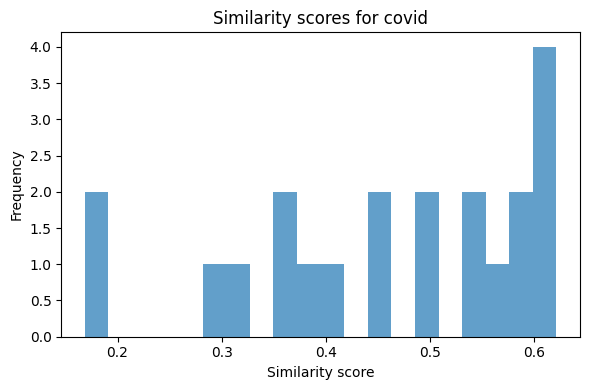

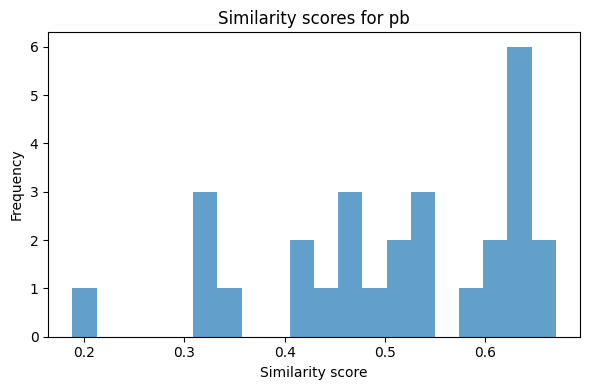

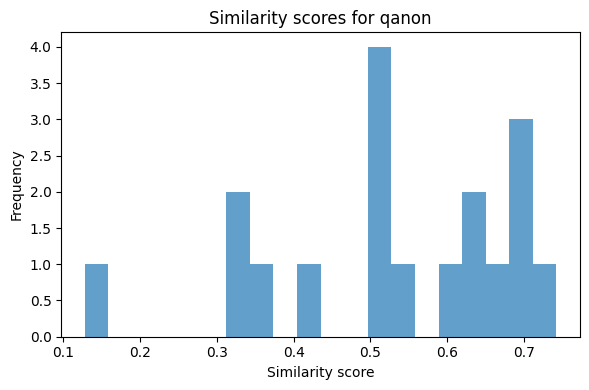

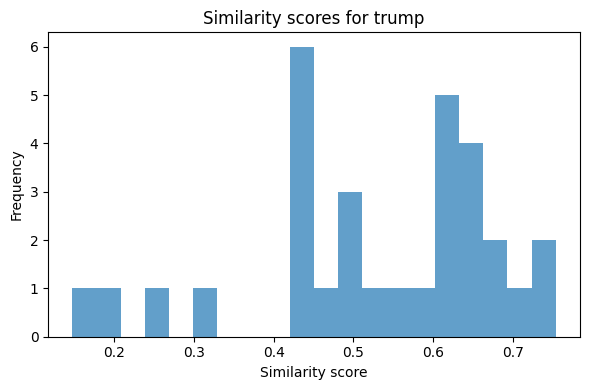

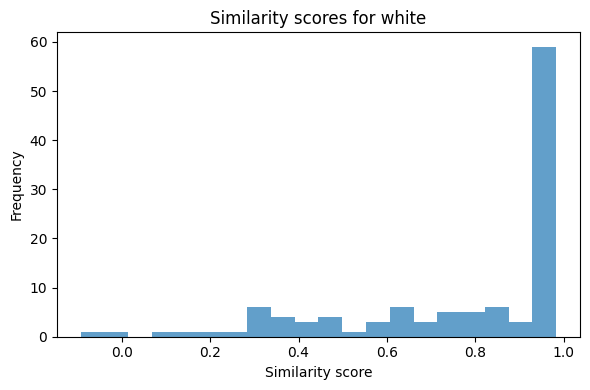

In [16]:
import matplotlib.pyplot as plt

# Clean column names for better titles
similarity_df_for_hist = similarity_df.rename(columns=lambda col: col.replace("sim_to_", ""))

# Plot histograms by true_type, only for numeric columns
for true_type, group in similarity_df_for_hist.groupby('true_type'):
    ax = group[[true_type]].plot.hist(
        bins=20, alpha=0.7, figsize=(6, 4), legend=False, title=f"Similarity scores for {true_type}"
    )
    ax.set_xlabel("Similarity score")
    ax.set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()

true_type
covid    [[Axes(0.125,0.666111;0.336957x0.213889), Axes...
pb       [[Axes(0.125,0.666111;0.336957x0.213889), Axes...
qanon    [[Axes(0.125,0.666111;0.336957x0.213889), Axes...
trump    [[Axes(0.125,0.666111;0.336957x0.213889), Axes...
white    [[Axes(0.125,0.666111;0.336957x0.213889), Axes...
dtype: object

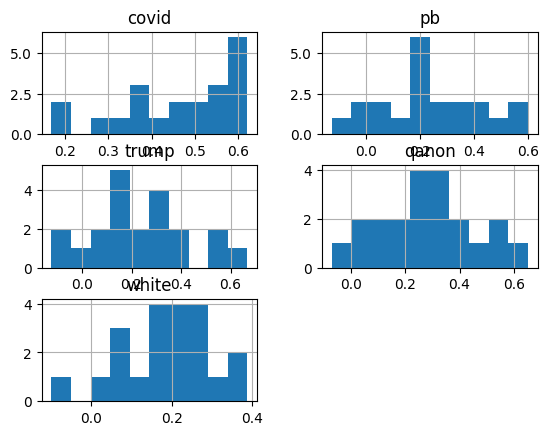

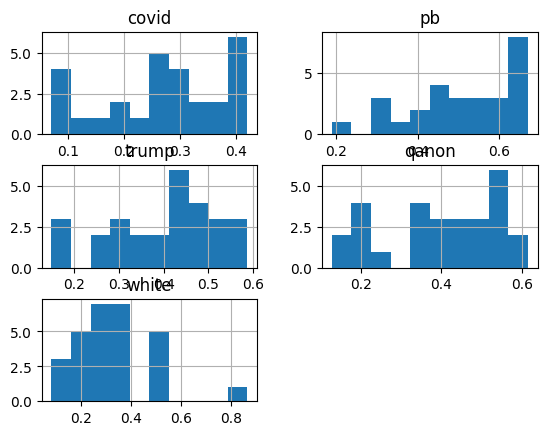

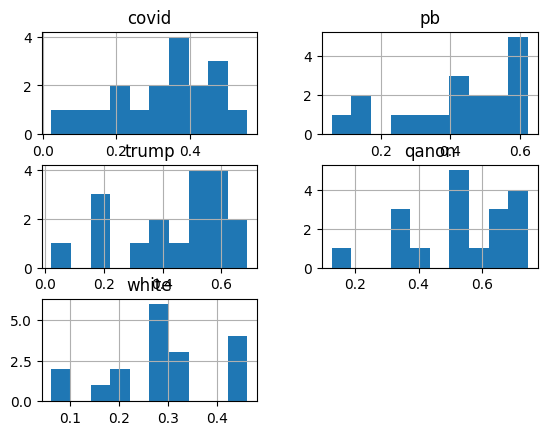

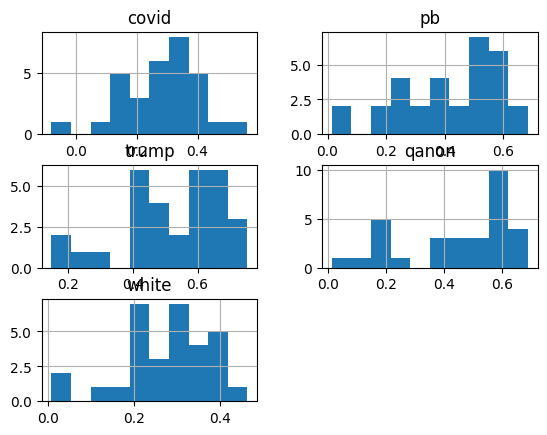

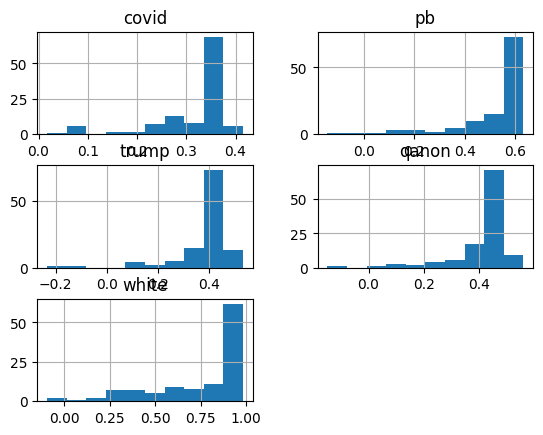

In [17]:
# Clean up column names for better titles
clean_names = {
    col: col.replace("sim_to_", "")
    for col in similarity_df.columns
}

# Rename columns
similarity_df_for_hist = similarity_df.rename(columns=clean_names)

# Plot hist by type
similarity_df_for_hist.groupby('true_type').hist()

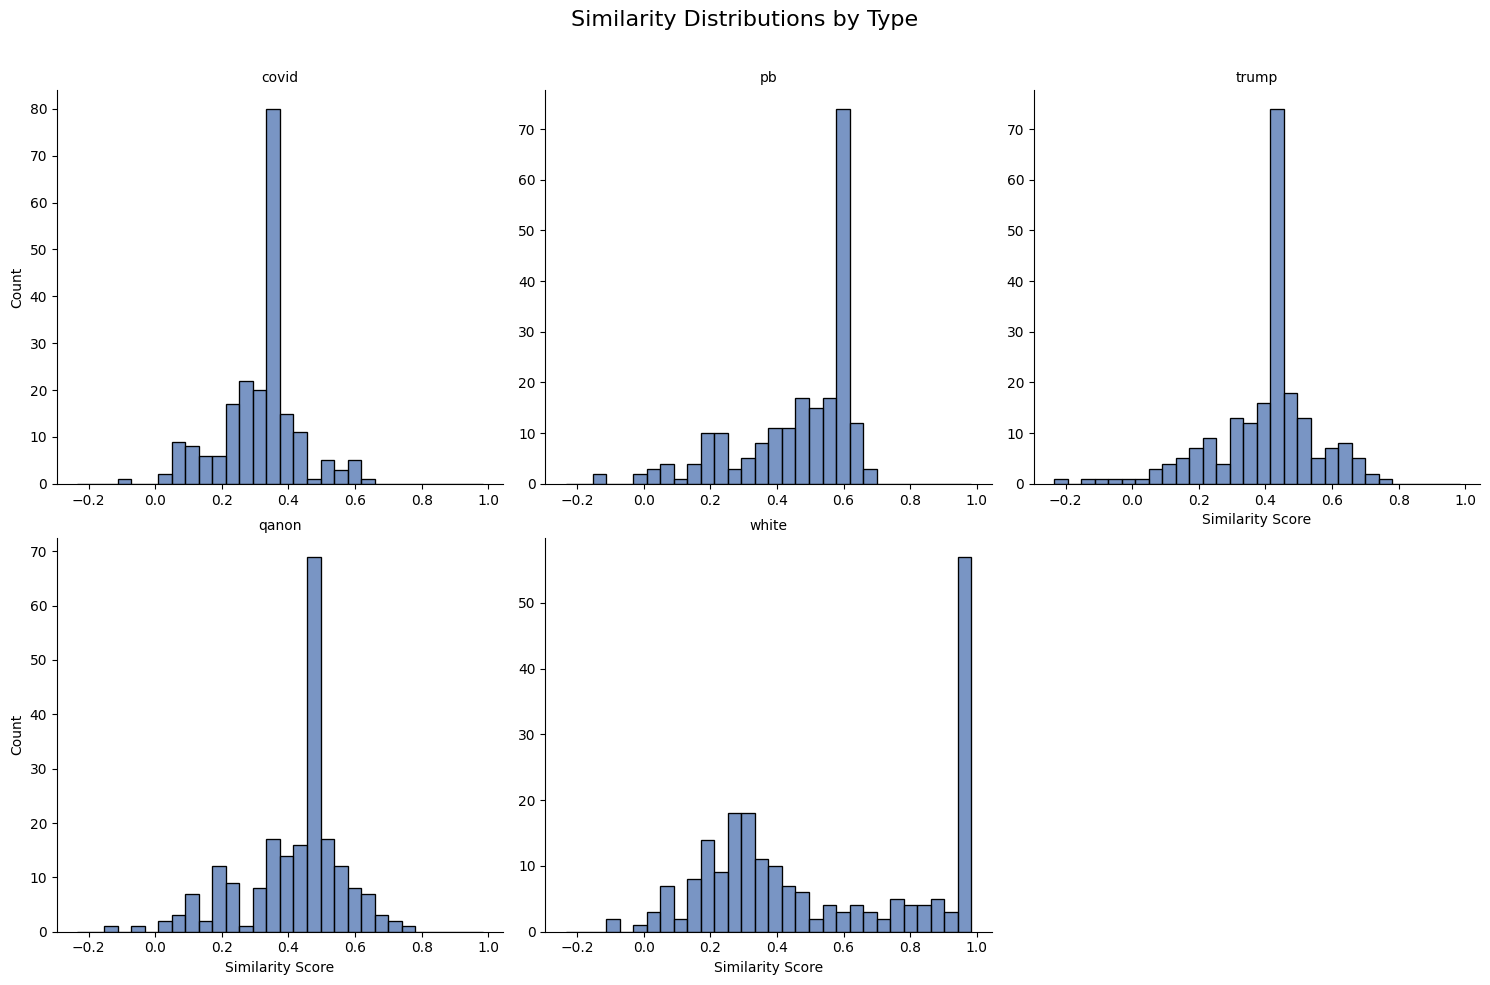

In [18]:
# Histogram: distance distribution for each true type

similarity_df_for_hist = similarity_df.filter(regex="^sim_to")

# Clean up column names for better titles
clean_names = {
    col: col.replace("sim_to_", "").replace("_", " ")
    for col in sim_cols.columns
}

# Rename columns
sim_columns_clean = sim_cols.rename(columns=clean_names)

# Melt the cleaned DataFrame
sim_long = sim_columns_clean.melt(var_name='Similarity To', value_name='Similarity Score')

# Plot
g = sns.displot(
    data=sim_long,
    x="Similarity Score",
    col="Similarity To",
    col_wrap=3,
    kind="hist",
    bins=30,
    facet_kws={'sharex': False, 'sharey': False},
    color="#4c72b0"
)

# Titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Similarity Score", "Count")
g.fig.suptitle("Similarity Distributions by Type", fontsize=16)
plt.subplots_adjust(top=0.9)  # Adjust for suptitle

plt.show()

<h2 style="text-align: center;">Process source channels</h2>


### All messages

In [19]:
# average_embedding_covid_source, channel_embeddings_covid_source, channel_messages_covid_source = get_average_embedding_by_channel(covid_source)
# average_embedding_pb_source, channel_embeddings_pb_source, channel_messages_pb_source = get_average_embedding_by_channel(pb_source)
# average_embedding_trump_source, channel_embeddings_trump_source, channel_messages_trump_source = get_average_embedding_by_channel(trump_source)
# average_embedding_qanon_source, channel_embeddings_qanon_source, channel_messages_qanon_source = get_average_embedding_by_channel(qanon_source)
# average_embedding_white_source, channel_embeddings_white_source, channel_messages_white_source = get_average_embedding_by_channel(white_source)

In [20]:
# Bundle all 1-year embedding objects into a dictionary
# objects_to_save = {
#     'average_embedding_covid_source': average_embedding_covid_source,
#     'channel_embeddings_covid_source': channel_embeddings_covid_source,
#     'channel_messages_covid_source': channel_messages_covid_source,
    
#     'average_embedding_pb_source': average_embedding_pb_source,
#     'channel_embeddings_pb_source': channel_embeddings_pb_source,
#     'channel_messages_pb_source': channel_messages_pb_source,
    
#     'average_embedding_trump_source': average_embedding_trump_source,
#     'channel_embeddings_trump_source': channel_embeddings_trump_source,
#     'channel_messages_trump_source': channel_messages_trump_source,
    
#     'average_embedding_qanon_source': average_embedding_qanon_source,
#     'channel_embeddings_qanon_source': channel_embeddings_qanon_source,
#     'channel_messages_qanon_source': channel_messages_qanon_source,
    
#     'average_embedding_white_source': average_embedding_white_source,
#     'channel_embeddings_white_source': channel_embeddings_white_source,
#     'channel_messages_white_source': channel_messages_white_source,
# }

# # Save to a pickle file
# with open("source_embeddings_pkl/embeddings_source.pkl", "wb") as f:
#     pickle.dump(objects_to_save, f)

# print("✅ Saved all 1-year embeddings to 'embeddings_source.pkl'")

# Load all objects from the pickle file
with open("source_embeddings_pkl/embeddings_source.pkl", "rb") as f:
    loaded_objects = pickle.load(f)

# Unpack each object into its corresponding variable
average_embedding_covid_source   = loaded_objects['average_embedding_covid_source']
channel_embeddings_covid_source  = loaded_objects['channel_embeddings_covid_source']
channel_messages_covid_source    = loaded_objects['channel_messages_covid_source']

average_embedding_pb_source      = loaded_objects['average_embedding_pb_source']
channel_embeddings_pb_source     = loaded_objects['channel_embeddings_pb_source']
channel_messages_pb_source       = loaded_objects['channel_messages_pb_source']

average_embedding_trump_source   = loaded_objects['average_embedding_trump_source']
channel_embeddings_trump_source  = loaded_objects['channel_embeddings_trump_source']
channel_messages_trump_source    = loaded_objects['channel_messages_trump_source']

average_embedding_qanon_source   = loaded_objects['average_embedding_qanon_source']
channel_embeddings_qanon_source  = loaded_objects['channel_embeddings_qanon_source']
channel_messages_qanon_source    = loaded_objects['channel_messages_qanon_source']

average_embedding_white_source   = loaded_objects['average_embedding_white_source']
channel_embeddings_white_source  = loaded_objects['channel_embeddings_white_source']
channel_messages_white_source    = loaded_objects['channel_messages_white_source']


In [21]:
average_embeddings = {
    'covid': average_embedding_covid_seed,
    'pb': average_embedding_pb_seed,
    'trump': average_embedding_trump_seed,
    'qanon': average_embedding_qanon_seed,
    'white': average_embedding_white_seed
}

# Dictionary of all channel embeddings
channel_embeddings_source = {
    'covid': channel_embeddings_covid_source,
    'pb': channel_embeddings_pb_source,
    'trump': channel_embeddings_trump_source,
    'qanon': channel_embeddings_qanon_source,
    'white': channel_embeddings_white_source
}

similarity_df_source = compute_channel_similarity_df(average_embeddings, channel_embeddings_source)

**Filter source channels (threshold = 20 forwards)**

In [22]:
SeedChannels = {'covid': covid_seed, 'pb': pb_seed, 'trump': trump_seed, 'qanon': qanon_seed, 'white': white_seed}
SourceChannels = {'covid': covid_source, 'pb': pb_source, 'trump': trump_source, 'qanon': qanon_source, 'white': white_source}

# This function processes a string and converts it into the corresponding dictionary.
def parse_telegram_dict_string(text):
    if not isinstance(text, str):
        return text
    
    if not (text.startswith('{') and text.endswith('}')):
        return text
    
    # Define the namespace for evaluation
    namespace = {
        'datetime': datetime,
        'tzinfo': datetime.timezone
    }
    
    try:
        # Use eval with a controlled namespace
        result = eval(text, {"__builtins__": {}}, namespace)
        return result
    except Exception as e:
        # Fallback to original text if parsing fails
        print(f"Error parsing: {e}")
        return text
    
def get_unique_source_channelIDs(DF):
    """
    This function takes a DataFrame and returns the dictionary of unique source channel IDs
    from the 'fwd_from' column, along with the number of times each source channel appeared as a source channel.
    """
    # Parse the 'fwd_from' column to extract channel IDs
    DF['fwd_from_dict'] = DF.fwd_from.apply(parse_telegram_dict_string)
    unique_source_channelIDs = defaultdict(int)
    for index, row in DF.iterrows():
        if row.fwd_from_dict == row.fwd_from_dict: # check if fwd_from is not NaN
            if row.fwd_from_dict['from_id'] != None and 'channel_id' in row.fwd_from_dict['from_id']:
                unique_source_channelIDs[row.fwd_from_dict['from_id']['channel_id']] += 1
    # print("Number of unique source channel IDs:", len(unique_source_channelIDs), "\n")
    return unique_source_channelIDs

channel_sorted_dict_mapping = {}
for channel_type in ['qanon', 'white', 'pb', 'trump', 'covid']:
    DF = SeedChannels[channel_type]
    unique_source_channelIDs = get_unique_source_channelIDs(DF)
    sorted_dict_desc = dict(sorted(unique_source_channelIDs.items(), key=lambda item: item[1], reverse=True))
    my_dict = sorted_dict_desc
    channel_sorted_dict_mapping[channel_type] = my_dict

# Print the channels that are group channels, i.e. not Broadcast channels.
channelID_channelName_dict = {}
for channel_type in ['qanon', 'white', 'pb', 'trump', 'covid']:
    num_forwards_received = []
    proportion_inchannel_messages = []
    for channel_id, count in channel_sorted_dict_mapping[channel_type].items():
        DF = SourceChannels[channel_type]
        # if count > 20: # since we dont care about channels with less than 10 forwards
        DF_thisChannel = DF[DF.channel_id == channel_id]
        if False in list(DF_thisChannel.post.unique()): # if the channel is a broadcast channel, post column will always be True
            print("Group channel: ", channel_type, channel_id, count) # this is a Group channel.
        elif len(DF_thisChannel) > 0: # making sure we were able to scrape this source channel
            channelID_channelName_dict[channel_id] = DF_thisChannel.channel_name.unique()[0]


C:\Users\167266\AppData\Local\Temp\ipykernel_11588\2002989506.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['fwd_from_dict'] = DF.fwd_from.apply(parse_telegram_dict_string)
C:\Users\167266\AppData\Local\Temp\ipykernel_11588\2002989506.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['fwd_from_dict'] = DF.fwd_from.apply(parse_telegram_dict_string)
C:\Users\167266\AppData\Local\Temp\ipykernel_11588\2002989506.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Group channel:  qanon 1298941870 1
Group channel:  white 1272592937 5
Group channel:  white 1438651740 2
Group channel:  white 2125828816 1
Group channel:  white 1465449957 1
Group channel:  pb 1364953552 2
Group channel:  pb 1506836877 1
Group channel:  covid 1596769897 42
Group channel:  covid 1445794050 2
Group channel:  covid 1926846367 1
Group channel:  covid 1989030976 1
Group channel:  covid 1740067621 1
Group channel:  covid 2077747727 1
Group channel:  covid 1789205591 1


In [23]:
from collections import ChainMap

similarity_df_source['channel_name'] = similarity_df_source['channel'].str.split('::').str[1]
similarity_df_source['channel_ID'] = similarity_df_source['channel_name'].map({v: k for k, v in channelID_channelName_dict.items()})
similarity_df_source['forward_count'] = similarity_df_source['channel_ID'].map(dict(ChainMap(*channel_sorted_dict_mapping.values())))
similarity_df_source = similarity_df_source[similarity_df_source['forward_count'] >= 20]

In [24]:
## Before filtering, I wasn't able to match 59 source channels with their ID

# similarity_df_source[similarity_df_source['channel_ID'].isna()]

In [25]:
similarity_df_source

,channel,true_type,sim_to_covid,sim_to_pb,sim_to_trump,sim_to_qanon,sim_to_white,predicted_type,mismatch,channel_name,channel_ID,forward_count
23,covid::BigBrotherWatchHQ,covid,0.425546,0.469307,0.477399,0.488436,0.286442,qanon,True,BigBrotherWatchHQ,1.655398e+09,34.0
26,covid::CIG_telegram,covid,0.212529,0.255327,0.252328,0.302026,0.201072,qanon,True,CIG_telegram,1.458480e+09,33.0
37,covid::Conscious_Souls,covid,0.236047,0.100159,0.041448,0.060349,0.144622,covid,False,Conscious_Souls,1.790583e+09,38.0
47,covid::DiedSuddenlyConnecticut,covid,0.247911,0.017591,0.140018,0.180257,0.061438,covid,False,DiedSuddenlyConnecticut,1.807866e+09,22.0
58,covid::DrSebiHeal,covid,0.197967,-0.012379,0.044675,0.046387,0.001515,covid,False,DrSebiHeal,2.100584e+09,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1758,white::redicetv,white,0.310604,0.464171,0.303532,0.312376,0.385706,pb,True,redicetv,1.192193e+09,41.0
1767,white::russvolcorps,white,0.135043,-0.099138,-0.171827,-0.084504,-0.074612,covid,True,russvolcorps,1.613928e+09,128.0
1787,white::thewesternchauvinist7,white,0.381722,0.466086,0.448589,0.434686,0.282107,pb,True,thewesternchauvinist7,1.884130e+09,47.0
1793,white::thuletide,white,0.245999,0.383146,0.169953,0.221294,0.401406,white,False,thuletide,1.288641e+09,31.0


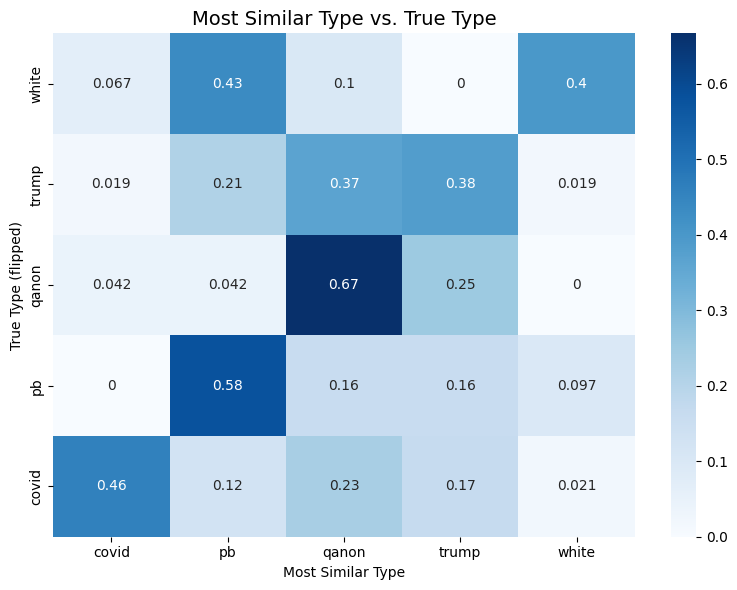

In [34]:
# Step 1: Select only the similarity columns
sim_cols = similarity_df_source.filter(regex="^sim_to")

# Step 2: Get the column (type) with highest similarity per row
most_similar_type = sim_cols.idxmax(axis=1)

# Step 3: Extract just the type name (e.g., 'covid' from 'sim_to_covid')
most_similar_type_clean = most_similar_type.str.replace("sim_to_", "", regex=False)

# Step 4: Combine with true_type
type_match_df = pd.DataFrame({
    'true_type': similarity_df_source['true_type'],
    'top_sim_type': most_similar_type_clean
})

# Step 5: Crosstabulate
match_table = pd.crosstab(type_match_df['true_type'], type_match_df['top_sim_type'], normalize='index')

# Step 6: Flip rows (index) to reverse y-axis
match_table_flipped = match_table.loc[match_table.index[::-1]]

# Step 7: Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(match_table_flipped, annot=True, cmap="Blues", cbar=True)

plt.title("Most Similar Type vs. True Type", fontsize=14)
plt.xlabel("Most Similar Type")
plt.ylabel("True Type (flipped)")
plt.tight_layout()
plt.show()


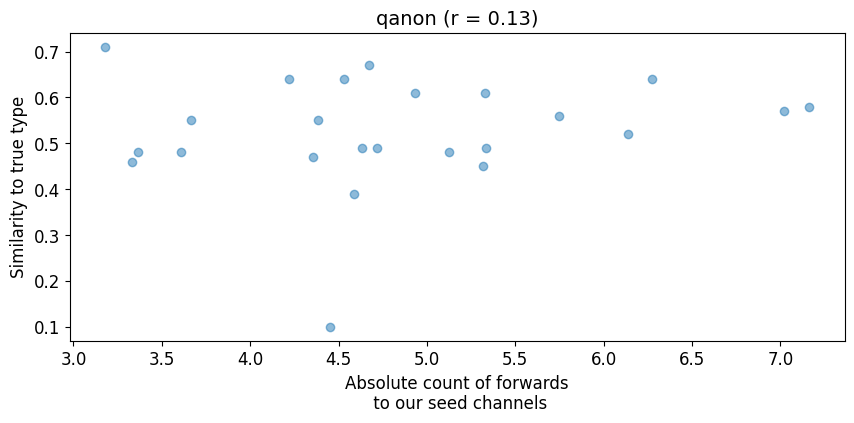

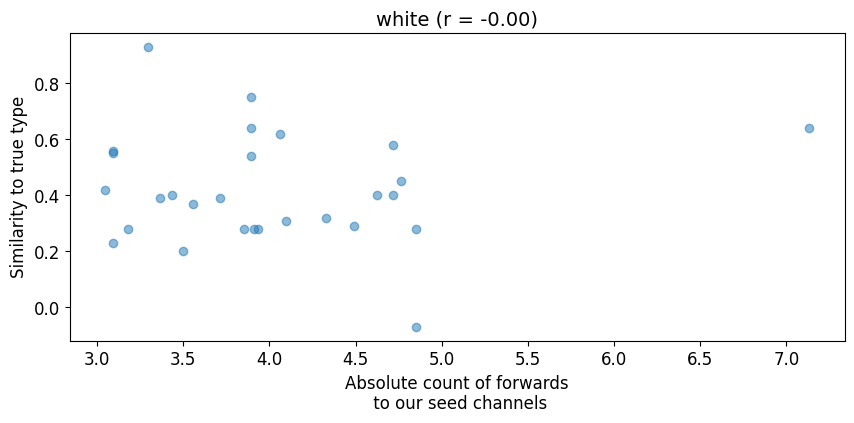

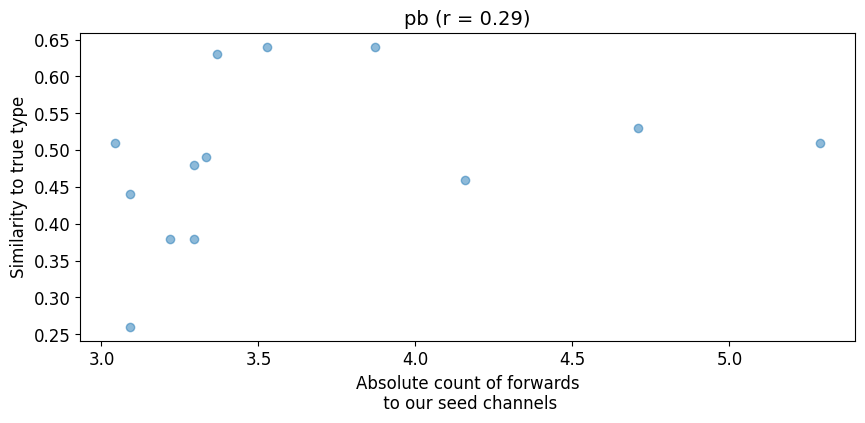

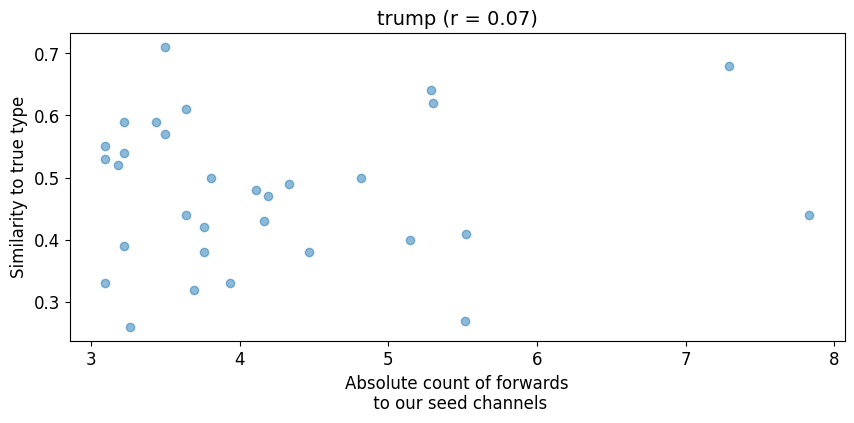

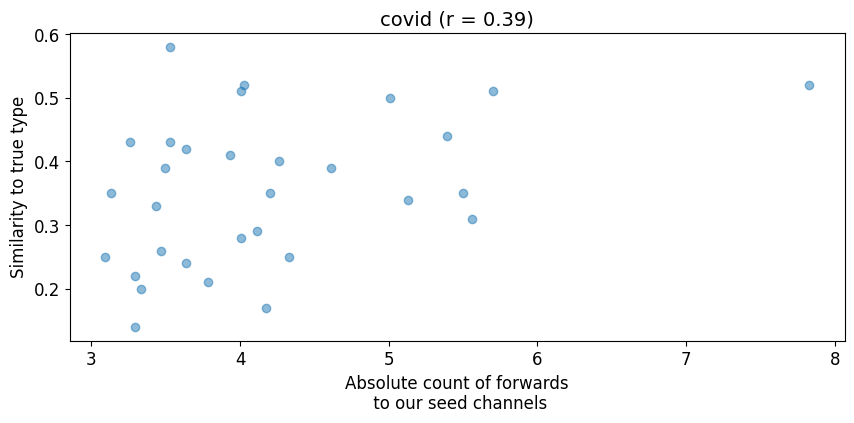

In [37]:
from scipy.stats import pearsonr
from math import log

# Clean up column names for better titles
clean_names = {
    col: col.replace("sim_to_", "").replace("_", " ")
    for col in sim_cols.columns
}

# Rename columns
similarity_df_source_clean = similarity_df_source.rename(columns=clean_names)

for channel_type in ['qanon', 'white', 'pb', 'trump', 'covid']:
    num_forwards_received = []
    similarities = []
    
    for channel_id, count in channel_sorted_dict_mapping[channel_type].items():
        if count > 20:
            num_forwards_received.append(count)
            sim_df = similarity_df_source_clean[similarity_df_source_clean['true_type'] == channel_type]
            match = similarity_df_source_clean.loc[similarity_df_source_clean['channel_ID'] == channel_id, channel_type]

            if not match.empty:
                similarities.append(round(match.iloc[0], 2))
            else:
                similarities.append(None)

    # Filter out None values before calculating correlation  # <-- ADDED
    valid_data = [(x, y) for x, y in zip(num_forwards_received, similarities) if y is not None]  # <-- ADDED
    x_vals, y_vals = zip(*valid_data) if valid_data else ([], [])  # <-- ADDED
    x_vals_log = [log(x) for x in x_vals]

    # Compute correlation  # <-- ADDED
    if len(x_vals_log) > 1:  # <-- ADDED
        corr_coef, _ = pearsonr(x_vals_log, y_vals)  # <-- ADDED
        title_text = f"{channel_type} (r = {corr_coef:.2f})"  # <-- ADDED
    else:  # <-- ADDED
        title_text = f"{channel_type} (r = N/A)"  # <-- ADDED

    # Plot
    plt.figure(figsize=(10, 4))
    plt.scatter(x_vals_log, y_vals, alpha=0.5)  # <-- updated from original variables
    plt.xlabel('Absolute count of forwards\n to our seed channels', fontsize=12)
    plt.ylabel('Similarity to true type', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title_text, fontsize=14)  # <-- updated to show correlation
    plt.show()


In [28]:
(0.17+0.18+0.18+0.10+0.31)/5

0.188

### Sample of messages

In [29]:
# Parameters
MIN_MSGS = 20       
MAX_MSGS = 100      
SAMPLE_PROP = 0.5

def hybrid_sample(group, min_msgs=MIN_MSGS, max_msgs=MAX_MSGS, prop=SAMPLE_PROP, seed=42):
    n = len(group)
    if n <= min_msgs:
        return group
    elif n >= max_msgs:
        return group.sample(n=max_msgs, random_state=seed)
    else:
        sample_n = int(n * prop)
        return group.sample(n=sample_n, random_state=seed)

# Apply the function to each topic DataFrame
covid_source_sampled = covid_source.groupby('sender_username', group_keys=False).apply(hybrid_sample)
pb_source_sampled = pb_source.groupby('sender_username', group_keys=False).apply(hybrid_sample)
trump_source_sampled = trump_source.groupby('sender_username', group_keys=False).apply(hybrid_sample)
white_source_sampled = white_source.groupby('sender_username', group_keys=False).apply(hybrid_sample)
qanon_source_sampled = qanon_source.groupby('sender_username', group_keys=False).apply(hybrid_sample)


# covid_source_100 = covid_source.groupby('sender_username').sample(frac=0.1, random_state=42)
# pb_source_100 = pb_source.groupby('sender_username').sample(frac=0.1, random_state=42)
# trump_source_100 = trump_source.groupby('sender_username').sample(frac=0.1, random_state=42)
# white_source_100 = white_source.groupby('sender_username').sample(frac=0.1, random_state=42)
# qanon_source_100 = qanon_source.groupby('sender_username').sample(frac=0.1, random_state=42)

C:\Users\167266\AppData\Local\Temp\ipykernel_11588\2697089576.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  covid_source_sampled = covid_source.groupby('sender_username', group_keys=False).apply(hybrid_sample)
C:\Users\167266\AppData\Local\Temp\ipykernel_11588\2697089576.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pb_source_sampled = pb_source.groupby('sender_username', group_keys=False).app

In [30]:
# average_embedding_covid_source_sampled, channel_embeddings_covid_source_sampled, channel_messages_covid_source_sampled = get_average_embedding_by_channel(covid_source_sampled)
# average_embedding_pb_source_sampled, channel_embeddings_pb_source_sampled, channel_messages_pb_source_sampled = get_average_embedding_by_channel(pb_source_sampled)
# average_embedding_trump_source_sampled, channel_embeddings_trump_source_sampled, channel_messages_trump_source_sampled = get_average_embedding_by_channel(trump_source_sampled)
# average_embedding_qanon_source_sampled, channel_embeddings_qanon_source_sampled, channel_messages_qanon_source_sampled = get_average_embedding_by_channel(white_source_sampled)
# average_embedding_white_source_sampled, channel_embeddings_white_source_sampled, channel_messages_white_source_sampled = get_average_embedding_by_channel(qanon_source_sampled)

In [31]:
# # Bundle all 1-year embedding objects into a dictionary
# objects_to_save = {
#     'average_embedding_covid_source_sampled': average_embedding_covid_source_sampled,
#     'channel_embeddings_covid_source_sampled': channel_embeddings_covid_source_sampled,
#     'channel_messages_covid_source_sampled': channel_messages_covid_source_sampled,
    
#     'average_embedding_pb_source_sampled': average_embedding_pb_source_sampled,
#     'channel_embeddings_pb_source_sampled': channel_embeddings_pb_source_sampled,
#     'channel_messages_pb_source_sampled': channel_messages_pb_source_sampled,
    
#     'average_embedding_trump_source_sampled': average_embedding_trump_source_sampled,
#     'channel_embeddings_trump_source_sampled': channel_embeddings_trump_source_sampled,
#     'channel_messages_trump_source_sampled': channel_messages_trump_source_sampled,
    
#     'average_embedding_qanon_source_sampled': average_embedding_qanon_source_sampled,
#     'channel_embeddings_qanon_source_sampled': channel_embeddings_qanon_source_sampled,
#     'channel_messages_qanon_source_sampled': channel_messages_qanon_source_sampled,
    
#     'average_embedding_white_source_sampled': average_embedding_white_source_sampled,
#     'channel_embeddings_white_source_sampled': channel_embeddings_white_source_sampled,
#     'channel_messages_white_source_sampled': channel_messages_white_source_sampled,
# }

# # Save to a pickle file
# with open("source_embeddings_pkl/embeddings_source_sampled.pkl", "wb") as f:
#     pickle.dump(objects_to_save, f)

# print("✅ Saved all 1-year embeddings to 'embeddings_source_sampled.pkl'")

# Load all objects from the pickle file
with open("source_embeddings_pkl/embeddings_source_sampled.pkl", "rb") as f:
    loaded_objects = pickle.load(f)

# Unpack each object into its corresponding variable
average_embedding_covid_source_sampled   = loaded_objects['average_embedding_covid_source_sampled']
channel_embeddings_covid_source_sampled  = loaded_objects['channel_embeddings_covid_source_sampled']
channel_messages_covid_source_sampled    = loaded_objects['channel_messages_covid_source_sampled']

average_embedding_pb_source_sampled      = loaded_objects['average_embedding_pb_source_sampled']
channel_embeddings_pb_source_sampled     = loaded_objects['channel_embeddings_pb_source_sampled']
channel_messages_pb_source_sampled       = loaded_objects['channel_messages_pb_source_sampled']

average_embedding_trump_source_sampled   = loaded_objects['average_embedding_trump_source_sampled']
channel_embeddings_trump_source_sampled  = loaded_objects['channel_embeddings_trump_source_sampled']
channel_messages_trump_source_sampled    = loaded_objects['channel_messages_trump_source_sampled']

average_embedding_qanon_source_sampled   = loaded_objects['average_embedding_qanon_source_sampled']
channel_embeddings_qanon_source_sampled  = loaded_objects['channel_embeddings_qanon_source_sampled']
channel_messages_qanon_source_sampled    = loaded_objects['channel_messages_qanon_source_sampled']

average_embedding_white_source_sampled   = loaded_objects['average_embedding_white_source_sampled']
channel_embeddings_white_source_sampled  = loaded_objects['channel_embeddings_white_source_sampled']
channel_messages_white_source_sampled    = loaded_objects['channel_messages_white_source_sampled']


C:\Users\167266\AppData\Local\Temp\ipykernel_11588\4012519102.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['fwd_from_dict'] = DF.fwd_from.apply(parse_telegram_dict_string)


Group channel:  qanon 1298941870 1
Group channel:  white 1272592937 5
Group channel:  white 1438651740 2
Group channel:  white 2125828816 1
Group channel:  white 1465449957 1
Group channel:  pb 1364953552 2
Group channel:  pb 1506836877 1
Group channel:  covid 1596769897 42
Group channel:  covid 1445794050 2
Group channel:  covid 1926846367 1
Group channel:  covid 1989030976 1
Group channel:  covid 1740067621 1
Group channel:  covid 2077747727 1
Group channel:  covid 1789205591 1


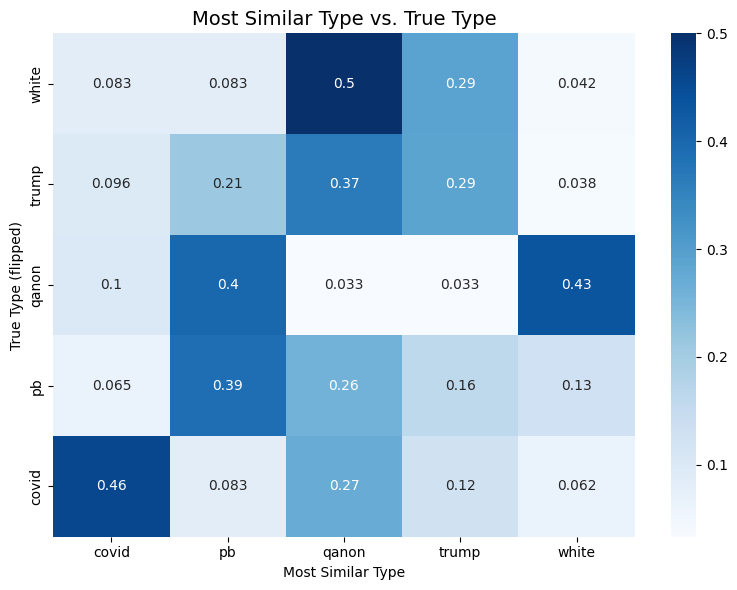

In [32]:
average_embeddings = {
    'covid': average_embedding_covid_seed,
    'pb': average_embedding_pb_seed,
    'trump': average_embedding_trump_seed,
    'qanon': average_embedding_qanon_seed,
    'white': average_embedding_white_seed
}

# Dictionary of all channel embeddings
channel_embeddings_source_sampled = {
    'covid': channel_embeddings_covid_source_sampled,
    'pb': channel_embeddings_pb_source_sampled,
    'trump': channel_embeddings_trump_source_sampled,
    'qanon': channel_embeddings_qanon_source_sampled,
    'white': channel_embeddings_white_source_sampled
}

similarity_df_source_sampled = compute_channel_similarity_df(average_embeddings, channel_embeddings_source_sampled)

SeedChannels = {'covid': covid_seed, 'pb': pb_seed, 'trump': trump_seed, 'qanon': qanon_seed, 'white': white_seed}
SourceChannels = {'covid': covid_source, 'pb': pb_source, 'trump': trump_source, 'qanon': qanon_source, 'white': white_source}

# This function processes a string and converts it into the corresponding dictionary.
def parse_telegram_dict_string(text):
    if not isinstance(text, str):
        return text
    
    if not (text.startswith('{') and text.endswith('}')):
        return text
    
    # Define the namespace for evaluation
    namespace = {
        'datetime': datetime,
        'tzinfo': datetime.timezone
    }
    
    try:
        # Use eval with a controlled namespace
        result = eval(text, {"__builtins__": {}}, namespace)
        return result
    except Exception as e:
        # Fallback to original text if parsing fails
        print(f"Error parsing: {e}")
        return text
    
def get_unique_source_channelIDs(DF):
    """
    This function takes a DataFrame and returns the dictionary of unique source channel IDs
    from the 'fwd_from' column, along with the number of times each source channel appeared as a source channel.
    """
    # Parse the 'fwd_from' column to extract channel IDs
    DF['fwd_from_dict'] = DF.fwd_from.apply(parse_telegram_dict_string)
    unique_source_channelIDs = defaultdict(int)
    for index, row in DF.iterrows():
        if row.fwd_from_dict == row.fwd_from_dict: # check if fwd_from is not NaN
            if row.fwd_from_dict['from_id'] != None and 'channel_id' in row.fwd_from_dict['from_id']:
                unique_source_channelIDs[row.fwd_from_dict['from_id']['channel_id']] += 1
    # print("Number of unique source channel IDs:", len(unique_source_channelIDs), "\n")
    return unique_source_channelIDs

channel_sorted_dict_mapping = {}
for channel_type in ['qanon', 'white', 'pb', 'trump', 'covid']:
    DF = SeedChannels[channel_type]
    unique_source_channelIDs = get_unique_source_channelIDs(DF)
    sorted_dict_desc = dict(sorted(unique_source_channelIDs.items(), key=lambda item: item[1], reverse=True))
    my_dict = sorted_dict_desc
    channel_sorted_dict_mapping[channel_type] = my_dict

# Print the channels that are group channels, i.e. not Broadcast channels.
channelID_channelName_dict = {}
for channel_type in ['qanon', 'white', 'pb', 'trump', 'covid']:
    num_forwards_received = []
    proportion_inchannel_messages = []
    for channel_id, count in channel_sorted_dict_mapping[channel_type].items():
        DF = SourceChannels[channel_type]
        # if count > 20: # since we dont care about channels with less than 10 forwards
        DF_thisChannel = DF[DF.channel_id == channel_id]
        if False in list(DF_thisChannel.post.unique()): # if the channel is a broadcast channel, post column will always be True
            print("Group channel: ", channel_type, channel_id, count) # this is a Group channel.
        elif len(DF_thisChannel) > 0: # making sure we were able to scrape this source channel
            channelID_channelName_dict[channel_id] = DF_thisChannel.channel_name.unique()[0]

from collections import ChainMap

similarity_df_source_sampled['channel_name'] = similarity_df_source_sampled['channel'].str.split('::').str[1]
similarity_df_source_sampled['channel_ID'] = similarity_df_source_sampled['channel_name'].map({v: k for k, v in channelID_channelName_dict.items()})
similarity_df_source_sampled['forward_count'] = similarity_df_source_sampled['channel_ID'].map(dict(ChainMap(*channel_sorted_dict_mapping.values())))
similarity_df_source_sampled = similarity_df_source_sampled[similarity_df_source_sampled['forward_count'] >= 20]
## Before filtering, I wasn't able to match 59 source channels with their ID

# Step 1: Select only the similarity columns
sim_cols = similarity_df_source_sampled.filter(regex="^sim_to")

# Step 2: Get the column (type) with highest similarity per row
most_similar_type = sim_cols.idxmax(axis=1)

# Step 3: Extract just the type name (e.g., 'covid' from 'sim_to_covid')
most_similar_type_clean = most_similar_type.str.replace("sim_to_", "", regex=False)

# Step 4: Combine with true_type
type_match_df = pd.DataFrame({
    'true_type': similarity_df_source_sampled['true_type'],
    'top_sim_type': most_similar_type_clean
})

# Step 5: Crosstabulate
match_table = pd.crosstab(type_match_df['true_type'], type_match_df['top_sim_type'], normalize='index')

# Step 6: Flip rows (index) to reverse y-axis
match_table_flipped = match_table.loc[match_table.index[::-1]]

# Step 7: Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(match_table_flipped, annot=True, cmap="Blues", cbar=True)

plt.title("Most Similar Type vs. True Type", fontsize=14)
plt.xlabel("Most Similar Type")
plt.ylabel("True Type (flipped)")
plt.tight_layout()
plt.show()


In [33]:
# Export list of source channels

similarity_df_source.to_excel('similarity_df_source.xlsx')

<h2 style="text-align: center;">Process mentioned channels</h2>


#### All messages

In [38]:
average_embedding_covid_mentioned, channel_embeddings_covid_mentioned, channel_messages_covid_mentioned = get_average_embedding_by_channel(covid_mentioned)
average_embedding_pb_mentioned, channel_embeddings_pb_mentioned, channel_messages_pb_mentioned = get_average_embedding_by_channel(pb_mentioned)
average_embedding_trump_mentioned, channel_embeddings_trump_mentioned, channel_messages_trump_mentioned = get_average_embedding_by_channel(trump_mentioned)
average_embedding_qanon_mentioned, channel_embeddings_qanon_mentioned, channel_messages_qanon_mentioned = get_average_embedding_by_channel(qanon_mentioned)
average_embedding_white_mentioned, channel_embeddings_white_mentioned, channel_messages_white_mentioned = get_average_embedding_by_channel(white_mentioned)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [42]:
# Bundle all 1-year embedding objects into a dictionary
objects_to_save = {
    'average_embedding_covid_mentioned': average_embedding_covid_mentioned,
    'channel_embeddings_covid_mentioned': channel_embeddings_covid_mentioned,
    'channel_messages_covid_mentioned': channel_messages_covid_mentioned,
    
    'average_embedding_pb_mentioned': average_embedding_pb_mentioned,
    'channel_embeddings_pb_mentioned': channel_embeddings_pb_mentioned,
    'channel_messages_pb_mentioned': channel_messages_pb_mentioned,
    
    'average_embedding_trump_mentioned': average_embedding_trump_mentioned,
    'channel_embeddings_trump_mentioned': channel_embeddings_trump_mentioned,
    'channel_messages_trump_mentioned': channel_messages_trump_mentioned,
    
    'average_embedding_qanon_mentioned': average_embedding_qanon_mentioned,
    'channel_embeddings_qanon_mentioned': channel_embeddings_qanon_mentioned,
    'channel_messages_qanon_mentioned': channel_messages_qanon_mentioned,
    
    'average_embedding_white_mentioned': average_embedding_white_mentioned,
    'channel_embeddings_white_mentioned': channel_embeddings_white_mentioned,
    'channel_messages_white_mentioned': channel_messages_white_mentioned,
}

# Save to a pickle file
with open("mentioned_embeddings_pkl/embeddings_mentioned.pkl", "wb") as f:
    pickle.dump(objects_to_save, f)

print("✅ Saved all 1-year embeddings to 'embeddings_mentioned.pkl'")

# Load all objects from the pickle file
with open("mentioned_embeddings_pkl/embeddings_mentioned.pkl", "rb") as f:
    loaded_objects = pickle.load(f)

# Unpack each object into its corresponding variable
average_embedding_covid_mentioned   = loaded_objects['average_embedding_covid_mentioned']
channel_embeddings_covid_mentioned  = loaded_objects['channel_embeddings_covid_mentioned']
channel_messages_covid_mentioned    = loaded_objects['channel_messages_covid_mentioned']

average_embedding_pb_mentioned      = loaded_objects['average_embedding_pb_mentioned']
channel_embeddings_pb_mentioned     = loaded_objects['channel_embeddings_pb_mentioned']
channel_messages_pb_mentioned       = loaded_objects['channel_messages_pb_mentioned']

average_embedding_trump_mentioned   = loaded_objects['average_embedding_trump_mentioned']
channel_embeddings_trump_mentioned  = loaded_objects['channel_embeddings_trump_mentioned']
channel_messages_trump_mentioned    = loaded_objects['channel_messages_trump_mentioned']

average_embedding_qanon_mentioned   = loaded_objects['average_embedding_qanon_mentioned']
channel_embeddings_qanon_mentioned  = loaded_objects['channel_embeddings_qanon_mentioned']
channel_messages_qanon_mentioned    = loaded_objects['channel_messages_qanon_mentioned']

average_embedding_white_mentioned   = loaded_objects['average_embedding_white_mentioned']
channel_embeddings_white_mentioned  = loaded_objects['channel_embeddings_white_mentioned']
channel_messages_white_mentioned    = loaded_objects['channel_messages_white_mentioned']


✅ Saved all 1-year embeddings to 'embeddings_mentioned.pkl'


In [52]:
average_embeddings = {
    'covid': average_embedding_covid_seed,
    'pb': average_embedding_pb_seed,
    'trump': average_embedding_trump_seed,
    'qanon': average_embedding_qanon_seed,
    'white': average_embedding_white_seed
}

# Dictionary of all channel embeddings
channel_embeddings_mentioned = {
    'covid': channel_embeddings_covid_mentioned,
    'pb': channel_embeddings_pb_mentioned,
    'trump': channel_embeddings_trump_mentioned,
    'qanon': channel_embeddings_qanon_mentioned,
    'white': channel_embeddings_white_mentioned
}

similarity_df_mentioned = compute_channel_similarity_df(average_embeddings, channel_embeddings_mentioned)
similarity_df_mentioned['channel_name'] = similarity_df_mentioned['channel'].str.split('::').str[1]
similarity_df_mentioned.head()

,channel,true_type,sim_to_covid,sim_to_pb,sim_to_trump,sim_to_qanon,sim_to_white,predicted_type,mismatch,channel_name
0,covid::AmericanGreyson,covid,0.305919,0.590025,0.640589,0.666307,0.412685,qanon,True,AmericanGreyson
1,covid::AussieCossack,covid,0.460405,0.417784,0.446071,0.428126,0.247096,covid,False,AussieCossack
2,covid::BigBrotherWatchHQ,covid,0.425546,0.469307,0.477399,0.488436,0.286442,qanon,True,BigBrotherWatchHQ
3,covid::COVID19VACCINEVICTIMSANDFAMILIES,covid,0.479552,0.348041,0.309723,0.343347,0.346713,covid,False,COVID19VACCINEVICTIMSANDFAMILIES
4,covid::CapitalistPigsCom,covid,0.409516,0.441756,0.344036,0.370572,0.319252,pb,True,CapitalistPigsCom


In [46]:
# this function processed the messages in the seed channels and extracts the mentioned channels that were mentioned more than a threshold number of times.
# It returns a dictionary of mentioned channels for each group with its corresponding frequency, as well as a list of frequencies of mentions to be used for histogram plotting later.

def extract_mentioned_channels_above_threshold(threshold = 5):
    group_mentioned_channels = {} # to store the final selected channels for each group after filtering on threshold
    frequency_of_mentions = [] # to store the frequency of mentions for each group for histogram plotting
    for group in ['covid', 'qanon', 'trump', 'white', 'pb']:
        DF = SeedChannels[group]
        count_messages_with_mentions = 0
        mentioned_channels = defaultdict(int)
        count_messages = 0
        for _, row in DF.iterrows():
            # we manually check for mentions in the entire message
            if row.message == row.message: # check if message is not empty
                count_messages += 1
                mentions = re.findall(r'(^|[^@\w])@([\w\d_]+)', row.message) # find ALL mentions in the message including the ones appearing in URLs if they have '@' in front of them
                for channel_name in mentions:
                    cleaned_channel_name = channel_name[1][1:].strip() if channel_name[1][0] == "@" else channel_name[1].strip()  # clean the channel name 

                    mentioned_channels[cleaned_channel_name] += 1 # remove the starting '@' from the channel name and count the mention

                if len(mentions) > 0: # if there is at least one mention in the message
                    count_messages_with_mentions += 1
        frequency_of_mentions.extend([value for key, value in mentioned_channels.items()]) # to plot histogram later
        
        # now sort the mentioned channels by their frequency of mentions in descending order and filter out those with less than X mentions
        sorted_dict = dict(sorted(mentioned_channels.items(), key=lambda item: item[1], reverse=True))
        selected_mentions = []
        for channel in sorted_dict:
            if sorted_dict[channel] >= threshold:
                selected_mentions.append((channel, sorted_dict[channel]))
        
        group_mentioned_channels[group] = selected_mentions
        
    return group_mentioned_channels, frequency_of_mentions

group_mentioned_channels, frequency_of_mentions = extract_mentioned_channels_above_threshold(threshold = 5)

In [57]:
group_mentioned_channels_nested = {
    key: dict(value) for key, value in group_mentioned_channels.items()
}

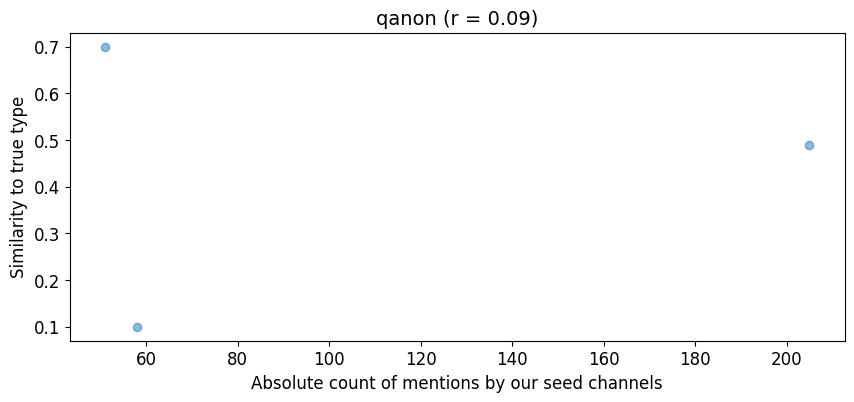

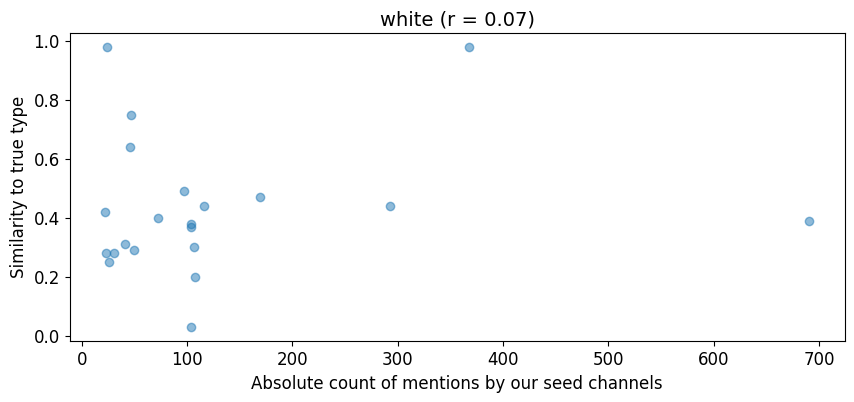

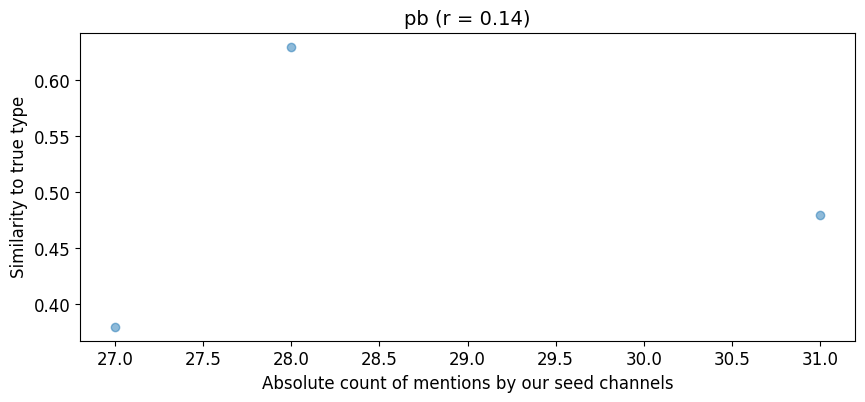

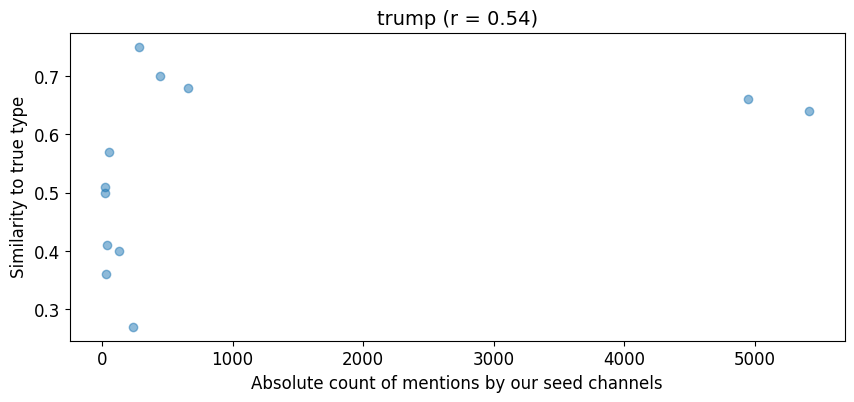

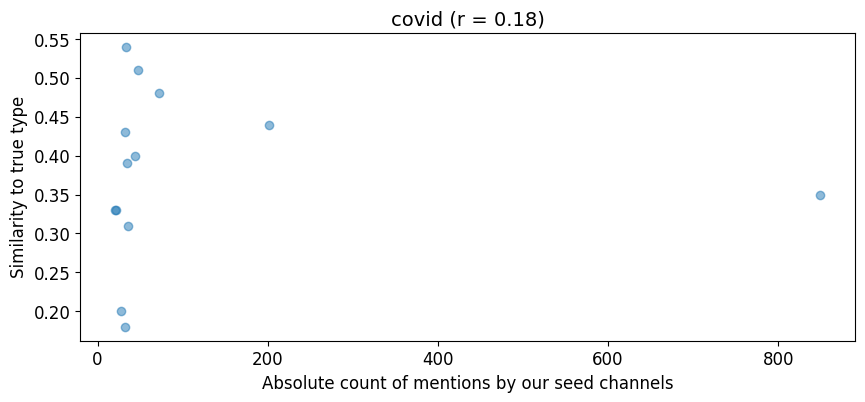

In [63]:
# Correlation between number of mentions and similarity to true_type

from scipy.stats import pearsonr
from math import log

# Clean up column names for better titles
clean_names = {
    col: col.replace("sim_to_", "").replace("_", " ")
    for col in sim_cols.columns
}

# Rename columns
similarity_df_mentioned_clean = similarity_df_mentioned.rename(columns=clean_names)

for channel_type in ['qanon', 'white', 'pb', 'trump', 'covid']:
    num_mentions = []
    similarities = []
    
    for channel_name, count in group_mentioned_channels_nested[channel_type].items():
        if count > 20:
            num_mentions.append(count)
            sim_df = similarity_df_mentioned_clean[similarity_df_mentioned_clean['true_type'] == channel_type]
            match = similarity_df_mentioned_clean.loc[similarity_df_mentioned_clean['channel_name'] == channel_name, channel_type]

            if not match.empty:
                similarities.append(round(match.iloc[0], 2))
            else:
                similarities.append(None)

    # Filter out None values before calculating correlation  # <-- ADDED
    valid_data = [(x, y) for x, y in zip(num_mentions, similarities) if y is not None]  # <-- ADDED
    x_vals, y_vals = zip(*valid_data) if valid_data else ([], [])  # <-- ADDED
    x_vals_log = [log(x) for x in x_vals]

    # Compute correlation  # <-- ADDED
    if len(x_vals_log) > 1:  # <-- ADDED
        corr_coef, _ = pearsonr(x_vals_log, y_vals)  # <-- ADDED
        title_text = f"{channel_type} (r = {corr_coef:.2f})"  # <-- ADDED
    else:  # <-- ADDED
        title_text = f"{channel_type} (r = N/A)"  # <-- ADDED

    # Plot
    plt.figure(figsize=(10, 4))
    plt.scatter(x_vals, y_vals, alpha=0.5)  # <-- updated from original variables
    plt.xlabel('Absolute count of mentions by our seed channels', fontsize=12)
    plt.ylabel('Similarity to true type', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title_text, fontsize=14)  # <-- updated to show correlation
    plt.show()


In [64]:
similarity_df_mentioned.to_excel("F:\._PhD\Publications\Hierarchy\Code\similarity_df_mentioned.xlsx")